# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1OqUBMKFIMYXwGWn2gINu7LPGCREXDFdf?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
#report min, max, average
columns = ["age", "yredu", "capgain", "caploss", "workhr"]
summary = df[columns].agg(['min', 'max', 'mean'])
summary

,age,yredu,capgain,caploss,workhr
min,17.000000,1.000000,0.000000,0.00000,1.000000
max,90.000000,16.000000,99999.000000,4356.00000,99.000000
mean,38.581647,10.080679,1077.648844,87.30383,40.437456


In [ ]:
#Min-Max Normalization
min_values = summary.loc['min']
max_values = summary.loc['max']
df[columns] = (df[columns]-min_values)/(max_values-min_values)
df[:3]

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.00000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.00000,0.0,0.397959,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
people = len(df)
male = sum(df["sex"] == " Male")
female = sum(df["sex"] == " Female")
print(f"Percentage of Male: {(male/people)*100}%")
print(f"Percentage of Female: {(female/people)*100}%")

Percentage of Male: 66.92054912318419%
Percentage of Female: 33.07945087681583%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(f"Total of {len(df_with_missing)} records contained missing features")
print(f"{(len(df_with_missing)/len(df))*100}% of records were removed")


Total of 1843 records contained missing features
5.660145572924664% of records were removed


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(f"data has a total of {len(data.columns)} columns")

data has a total of 57 columns


In [ ]:
#df_not_missing has 11 columns, but dataframe data used one hot encoding on some of the columns of df_not_missing; therefore, the number of columns increases
#Ex. column "work" will be represented by 7 columns, each corresponds to a value of "work", in dataframe data.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    ind = np.argmax(onehot)
    return (cat_values[feature])[ind]

In [ ]:
#Testing get_categorical_value function
print(get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work"))
print(get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work"))

State-gov
Private


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html

np.random.seed(50)

# todo
import math
from torch.utils.data.sampler import SubsetRandomSampler
print(datanp.shape)

indices = list(range(len(datanp)))
np.random.shuffle(indices)

train_val_cut = math.floor(len(datanp)*0.7) #Between train and validation
val_test_cut = train_val_cut + math.floor(len(datanp)*0.15) #Between validation and test

train_indices = indices[:train_val_cut]
val_indices = indices[train_val_cut:val_test_cut]
test_indices = indices[val_test_cut:]

#Random inside train, validation, and test set
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = torch.utils.data.DataLoader(datanp, batch_size=32, num_workers=1, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(datanp, batch_size=32, num_workers=1, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(datanp, batch_size=32, num_workers=1, sampler=test_sampler)


def inspect_loader(loader):
    total_samples = 0

    for item in loader:
        batch_size = item.size(0)
        total_samples += batch_size

    return total_samples


print(f"Number of items in train: {inspect_loader(train_loader)}")
print(f"Number of items in validation: {inspect_loader(val_loader)}")
print(f"Number of items in test: {inspect_loader(test_loader)}")

(30718, 57)
Number of items in train: 21502
Number of items in validation: 4607
Number of items in test: 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 24), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(24,12),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(12, 24), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(24,57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
#Because the data has been normalized to [0,1], the one-hot encoded columns can also take only value 0 and 1

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib.pyplot as plt
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

#Helper function
def plot(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record, start = None, end = None):
    if start == None and end == None:
      keys = list(train_loss_record.keys())
      train_loss = list(train_loss_record.values())
      val_loss = list(val_loss_record.values())

      train_acc = list(train_accuracy_record.values())
      val_acc = list(val_accuracy_record.values())
    else:
      keys = list(train_loss_record.keys())[start:end]
      train_loss = list(train_loss_record.values())[start:end]
      val_loss = list(val_loss_record.values())[start:end]

      train_acc = list(train_accuracy_record.values())[start:end]
      val_acc = list(val_accuracy_record.values())[start:end]

    plt.figure(figsize=(10, 6))
    plt.plot(keys,train_loss, label='Training Loss')
    plt.plot(keys,val_loss, label='Validation Loss', linestyle='--')
    plt.xlabel('Iteration (x5000)')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss plot')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(keys,train_acc, label='Training Accuracy')
    plt.plot(keys,val_acc, label='Validation Accuracy', linestyle='--')
    plt.xlabel('Iteration (x5000)')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy plot')
    plt.legend()
    plt.grid(True)
    plt.show()
def get_model_name(learning_rate, epoch, batch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_lr{0}_epoch{1}_batch{2}".format(learning_rate,
                                                   epoch,
                                                   batch)
    return path

def evaluate(net,loader,criterion):
    total_loss = 0
    total_num = 0

    for x in loader:
      datam = zero_out_random_feature(x.clone()) # zero out one categorical feature
      recon = net(datam)
      loss = criterion(recon,x)
      total_loss += loss.item()
      total_num += 1 #Average across every batch

    return total_loss/total_num

def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_record = dict()
    val_loss_record = dict()

    train_accuracy_record = dict()
    val_accuracy_record = dict()

    for epoch in range(num_epochs):
        train_loss = 0
        for i, data in enumerate(train_loader):

            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()
            if (i+1) % 100 == 0:

                avg_train_loss = train_loss / 100
                train_loss = 0

                train_loss_record[f"({epoch},{i+1})"] = avg_train_loss
                val_loss = evaluate(model, valid_loader, nn.MSELoss())
                val_loss_record[f"({epoch},{i+1})"] = val_loss

                train_acc = get_accuracy(model, train_loader)
                val_acc = get_accuracy(model, valid_loader)
                train_accuracy_record[f"({epoch},{i+1})"] = train_acc
                val_accuracy_record[f"({epoch},{i+1})"] = val_acc

                print(f"At epoch:{epoch}, iteration:{i+1}; Train Loss = {avg_train_loss} Validation Loss = {val_loss}, Train Accuracy = {train_acc} Validation Accuracy = {val_acc}")

                model_path = get_model_name(learning_rate, epoch, i+1)
                torch.save(model.state_dict(), model_path)
    return train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

At epoch:0, iteration:100; Train Loss = 0.23733536437153815 Validation Loss = 0.23294911792294848, Train Accuracy = 0.1467692927789663 Validation Accuracy = 0.14763765284711672
At epoch:0, iteration:200; Train Loss = 0.22749810799956321 Validation Loss = 0.22079457694457638, Train Accuracy = 0.15188509596006572 Validation Accuracy = 0.15371536068301858
At epoch:0, iteration:300; Train Loss = 0.21113947823643683 Validation Loss = 0.19870050779233375, Train Accuracy = 0.19056366849595385 Validation Accuracy = 0.19307575428695464
At epoch:0, iteration:400; Train Loss = 0.18030465096235276 Validation Loss = 0.15858299440393844, Train Accuracy = 0.3002201345611261 Validation Accuracy = 0.30254684899790174
At epoch:0, iteration:500; Train Loss = 0.13508102625608445 Validation Loss = 0.11284579186596805, Train Accuracy = 0.36553188850649554 Validation Accuracy = 0.36531365313653136
At epoch:0, iteration:600; Train Loss = 0.09770404078066348 Validation Loss = 0.08644950384688047, Train Accurac

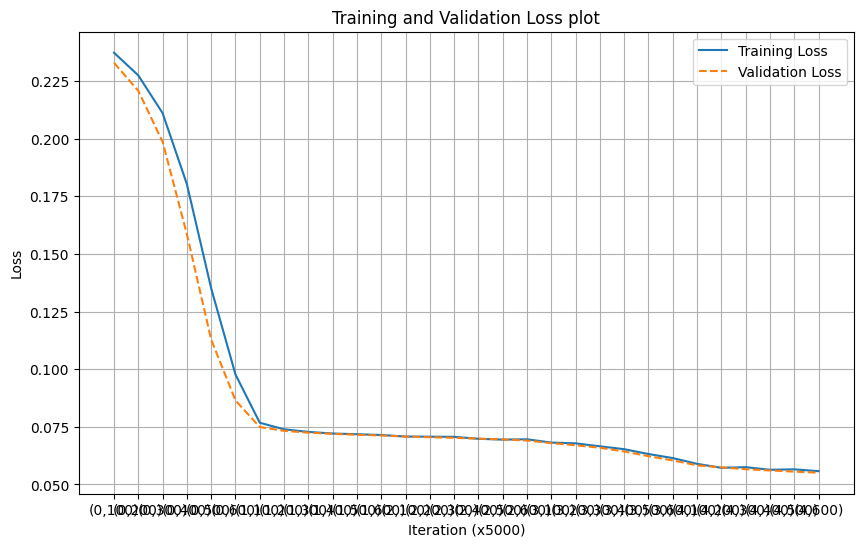

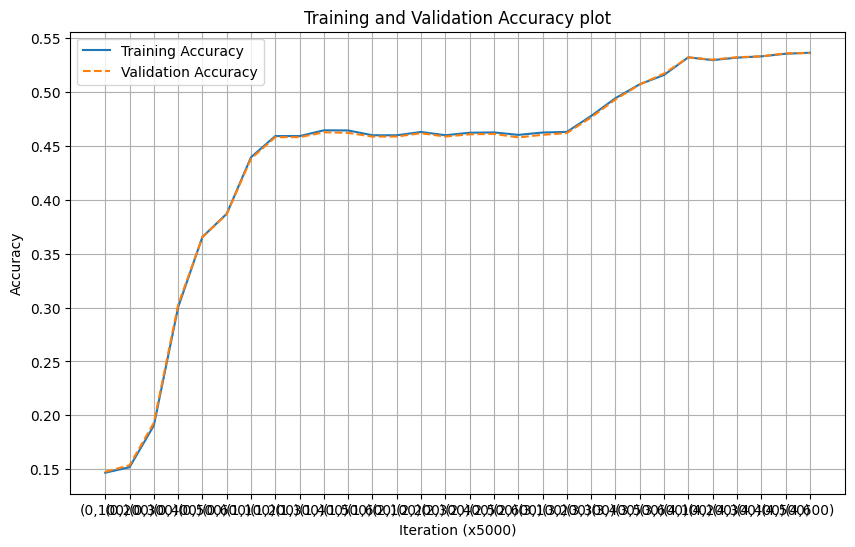

In [ ]:
ae = AutoEncoder()
train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(ae, train_loader, val_loader)
plot(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

In [ ]:
def get_best_model(val_accuracy_record):
      keys = list(val_accuracy_record.keys())
      acc = list(val_accuracy_record.values())
      ind = np.argmax(acc)

      return (keys[ind], acc[ind])

In [ ]:
#increase num_epoch because the model hasn't passed the point of overfitting
ae = AutoEncoder()
train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(ae, train_loader, val_loader,num_epochs=8)

At epoch:0, iteration:100; Train Loss = 0.24014712125062943 Validation Loss = 0.23694984449280632, Train Accuracy = 0.10460267261960128 Validation Accuracy = 0.10585341147529122
At epoch:0, iteration:200; Train Loss = 0.23346079111099244 Validation Loss = 0.22929812036454678, Train Accuracy = 0.10750937897249868 Validation Accuracy = 0.10878373489617249
At epoch:0, iteration:300; Train Loss = 0.22303060457110405 Validation Loss = 0.21499332330293125, Train Accuracy = 0.18268843208383717 Validation Accuracy = 0.18287388756240502
At epoch:0, iteration:400; Train Loss = 0.20184045568108558 Validation Loss = 0.18418862236042818, Train Accuracy = 0.3626639382383034 Validation Accuracy = 0.3632877505245641
At epoch:0, iteration:500; Train Loss = 0.1602937351167202 Validation Loss = 0.13459523332615694, Train Accuracy = 0.40748147459151085 Validation Accuracy = 0.4068808335142175
At epoch:0, iteration:600; Train Loss = 0.11376267001032829 Validation Loss = 0.09735630887250106, Train Accuracy 

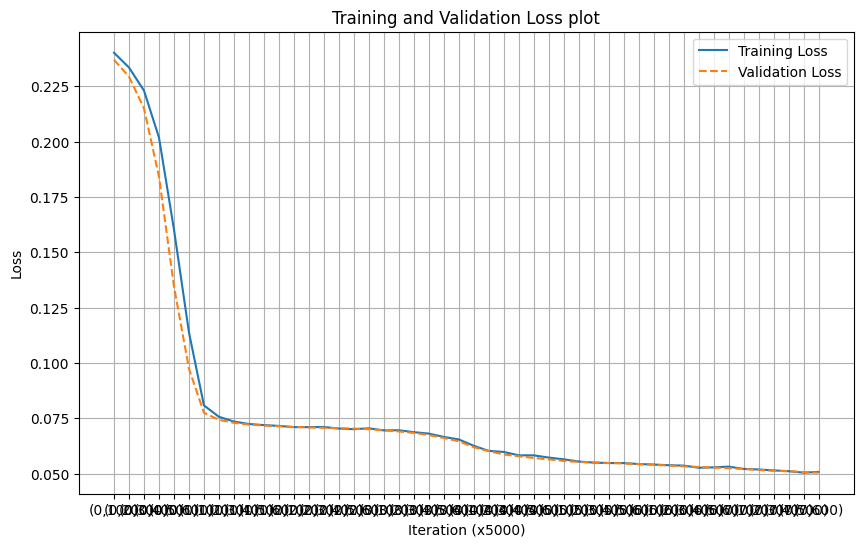

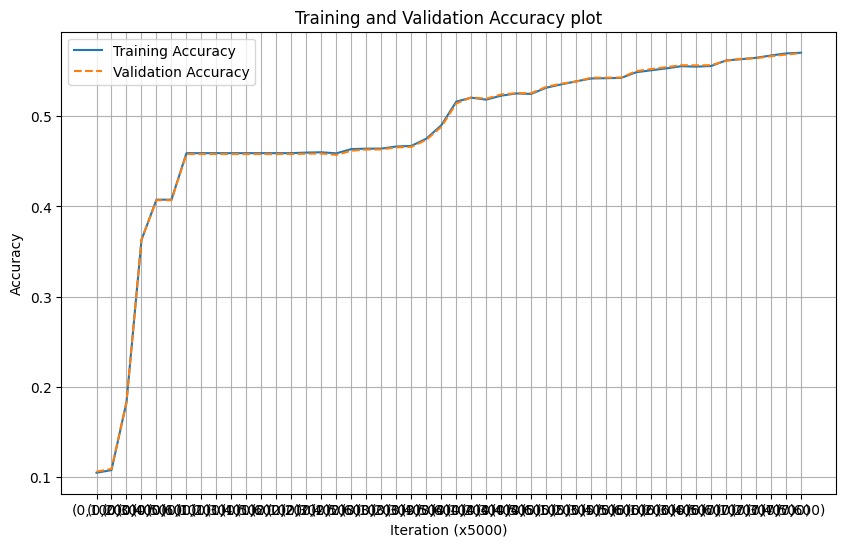

In [ ]:
plot(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record)

In [ ]:
get_best_model(val_accuracy_record)

('(7,600)', 0.570038347442298)

At epoch:0, iteration:100; Train Loss = 0.14943280898034572 Validation Loss = 0.07331318299596508, Train Accuracy = 0.4482606269184262 Validation Accuracy = 0.4468200564358585
At epoch:0, iteration:200; Train Loss = 0.07153491578996181 Validation Loss = 0.07057393225841224, Train Accuracy = 0.45940687687967013 Validation Accuracy = 0.4583966427899573
At epoch:0, iteration:300; Train Loss = 0.07034367278218269 Validation Loss = 0.06920117926266459, Train Accuracy = 0.45907357455120457 Validation Accuracy = 0.45807105129874826
At epoch:0, iteration:400; Train Loss = 0.06697291161864996 Validation Loss = 0.06220279481365449, Train Accuracy = 0.500263541375996 Validation Accuracy = 0.49602054844077853
At epoch:0, iteration:500; Train Loss = 0.057903475537896154 Validation Loss = 0.056214917477013335, Train Accuracy = 0.5333302328465569 Validation Accuracy = 0.5354894725417843
At epoch:0, iteration:600; Train Loss = 0.055720985755324366 Validation Loss = 0.054850738081667155, Train Accuracy

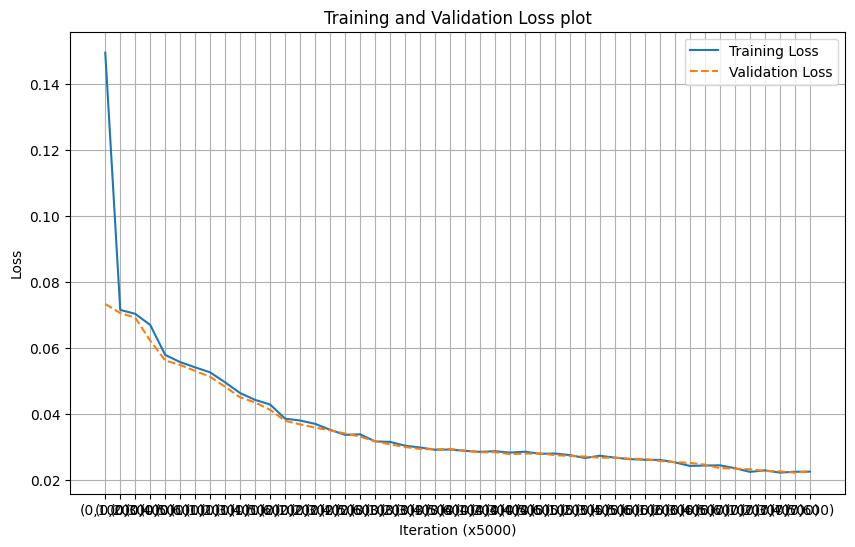

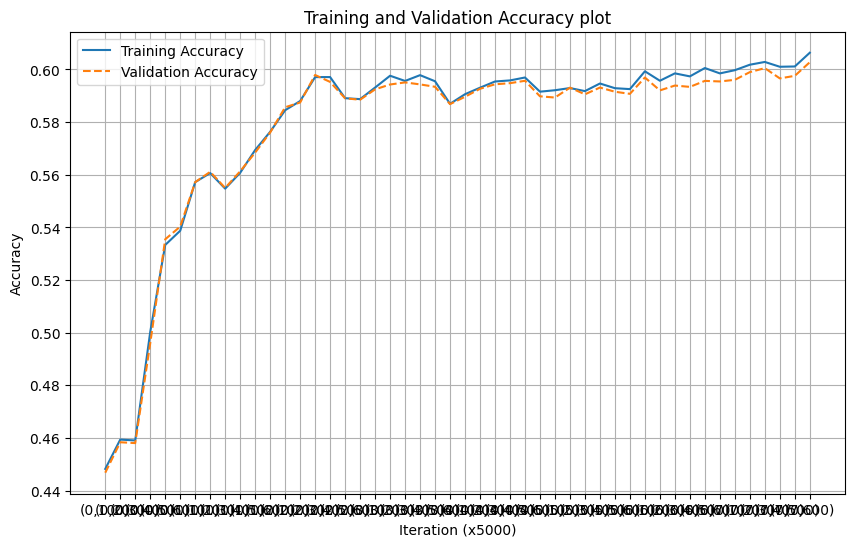

In [ ]:
#Increasing num_epochs still has not make the model pass the point of overfitting; so, I will increase the learning rate, hoping the model could learn faster without being too aggressive.
ae = AutoEncoder()
train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(ae, train_loader, val_loader,num_epochs=8, learning_rate = 1e-3)
plot(train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record)

In [ ]:
#The model performed better
get_best_model(val_accuracy_record)

('(7,600)', 0.6027422038926271)

In [ ]:
#It looks like the model is able to learn faster, and the graph does not look too aggressive; so, I will increase the learning rate even more
ae = AutoEncoder()
train_loss_record, val_loss_record, train_accuracy_record, val_accuracy_record = train(ae, train_loader, val_loader,num_epochs=8, learning_rate = 5*1e-3)
get_best_model(val_accuracy_record)

At epoch:0, iteration:100; Train Loss = 0.09022060357034206 Validation Loss = 0.0644335610171159, Train Accuracy = 0.47995535299041947 Validation Accuracy = 0.476955357788872
At epoch:0, iteration:200; Train Loss = 0.05664133884012699 Validation Loss = 0.05422035599541333, Train Accuracy = 0.559676619229219 Validation Accuracy = 0.559872657550105
At epoch:0, iteration:300; Train Loss = 0.05300431292504072 Validation Loss = 0.05201162762629489, Train Accuracy = 0.5567931665271447 Validation Accuracy = 0.560198249041314
At epoch:0, iteration:400; Train Loss = 0.04758952517062426 Validation Loss = 0.04256729711778462, Train Accuracy = 0.5665131925712337 Validation Accuracy = 0.5678315606685479
At epoch:0, iteration:500; Train Loss = 0.03956009702757001 Validation Loss = 0.03888166620809999, Train Accuracy = 0.5828140017982824 Validation Accuracy = 0.5810361044786918
At epoch:0, iteration:600; Train Loss = 0.037988468669354916 Validation Loss = 0.036927708101251885, Train Accuracy = 0.5929

('(6,100)', 0.6150785037262138)

In [ ]:
#Now, we have tried 4 sets of hyperparameters (including the default hyperparameters from 3c). The best model comes from the last set of hyperparameters where we have a
#very high learning rate and num_epochs. It is able to achieve validation accuracy of 0.615.

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
#Load weights from the best model
best_ae = AutoEncoder()
model_path = get_model_name(5*1e-3, 6, 100)
state = torch.load(model_path)
best_ae.load_state_dict(state)

<ipython-input-45-1fd457372cd4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)


<All keys matched successfully>

In [ ]:
print(f"Best Test Accuracy: {get_accuracy(best_ae, test_loader)}")

Best Test Accuracy: 0.6160772401822521


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
catcols

['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']

In [ ]:
df_not_missing.reset_index(drop=True, inplace=True)

In [ ]:
train_data = df_not_missing.iloc[train_indices]
test_data = df_not_missing.iloc[test_indices]

baseline = {}

# Get the mode for each column
for column in catcols:
    baseline[column] = train_data[column].mode()[0]
baseline

{'work': ' Private',
 'marriage': ' Married-civ-spouse',
 'occupation': ' Prof-specialty',
 'edu': ' HS-grad',
 'relationship': ' Husband',
 'sex': ' Male'}

In [ ]:
err = 0
for index, row in test_data.iterrows():
    missing = random.choice(catcols)
    if row[missing] != baseline[missing]:
        err += 1
err = err/len(test_data)
print(f"Test Accuracy = {(1-err)*100}%")

Test Accuracy = 46.582772835756124%


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
#Test Accuracy from part a is 61.6 %, while test accuracy from baseline is 46.6%; therefore, the neural network is able to perform alot better.

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
test_data[:1]
#Yes, you can probably guess the education level based on features like age and workhr. For example, 6th grade start at age 11-12 and people who are studying will probably have low workhr.
#Other features will also help with the guessing.

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
21870,0.0,0.4,0.0,0.0,0.153061,Private,Never-married,Transport-moving,11th,Own-child,Female


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
t = torch.tensor(datanp[test_indices[0]])
t = t.reshape(1,57)
t = zero_out_feature(t.clone(), "edu")

out = best_ae(t).detach().numpy()
get_feature(out[0], "edu")

'HS-grad'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
#Baseline predicts HS-grad

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 6 image(s).
[NbConvertApp] Writing 885919 bytes to /content/Lab4_Data_Imputation.html
